# First example of causal discovery

### Goal of this notebook: 

show that causal discovery using CMI queries works for linear, continuous-valued data and three different structures.

The logPDF of the observation functions is computed as follows:

$ \sum_{a,b,c} \log P\bigg(CMI(a ,b \mid c) > \epsilon \bigg) +
\sum_{x,y,z}\log P\bigg(\neg\big(CMI(x ,y \mid z) > \epsilon \big)\bigg)$

where $\{a, b, c\}$ and $\{ x, y, z\}$ are dependent or independent nodes in the causal DAG to learn. A sampled DAG structure determines which
independence statements are true and which false, therefore determining which of the binary CMI probabilities needs to be negated ($\neg$). Here by negated we mean:

$1 - P\bigg(\big(CMI(x ,y \mid z)\bigg) = P\bigg(\neg\big(CMI(x ,y \mid z)\bigg)$.

This allows one to compute the  equivalence classes of causal DAG as posterior distributions over possible structures (assuming causal 
faithfulness).

In the following, this notebooks demonstrates that this premise is true.

### Table of contents
1. Synthetic Data
2. BDB - Population and Analysis 
3. Causal discovery for  two independent nodes
4. Causal discovery for  two dependent nodes
5. Causal discovery for a V-structure
6. Known issues

In [1]:
%%capture
from synth_data_generator import generate_linear_data 
%load_ext iventure.magics
%matplotlib inline

## 1. Synthetic Data

#### todo: make a markov-chain / common-cause.

The following graphical model is used to generate N datapoints: 

![title](img/causal_example.png)
__Figure 1: Causal graphical model.__ The model above was used for generating synthetic data. 

Further, the following linear generative system was used:

### (i)

$ a  \sim \mathcal{N}(0,2)$

$ b  \sim \mathcal{N}(0,2)$

### (ii)

$ c  \sim \mathcal{N}(0,2)$

$ d  \sim \mathcal{N}(3 c,1)$

### (iii)

$ e  \sim \mathcal{N}(0,2)$

$ f  \sim \mathcal{N}(0,2)$

$ g  \sim \mathcal{N}(2e + 2f,1)$


##### We generate $N$ data points:

In [2]:
N = 100

### Plotting the population
Below, we plot all data generated with using the generator described above.
Variables (a) to (g) are all part of the data table that is used for the population below.

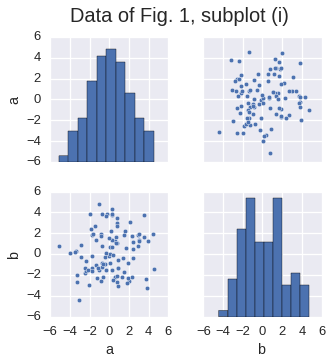

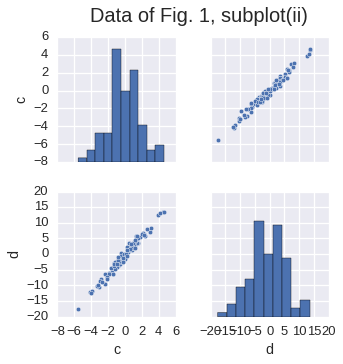

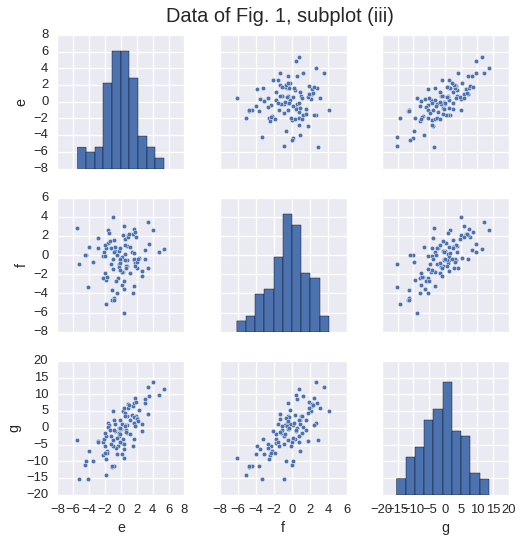

In [3]:
generate_linear_data(N)

## 2. BDB - Population and Analysis 

Below, we create and analyze a population for the data displayed above. For
this population, we will later compile a DAG to a set of queries to assess
the probability of mutual information as implied by the (conditional) dependence implied by the DAG. For now, we only consider cases where data generator and DAG are causally "faithful".

In [4]:
%bayesdb -j bdb_files/causal_linear.bdb

u'Loaded: bdb_files/causal_linear.bdb'

We check that the that dependence probability heatmap looks as expected:

/scratch/ulli/venv/local/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/scratch/ulli/venv/local/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


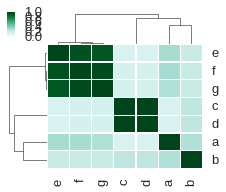

In [5]:
%%bql 
.clustermap 
    ESTIMATE DEPENDENCE PROBABILITY 
        FROM PAIRWISE COLUMNS OF causal_linear_population;

## 3. Causal discovery for  two independent nodes

#### Data as in  Fig. 1 subplot (i).

In [6]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


Below, we define population, metamodel and  .bdb file.

In [7]:
%%venturescript
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";

Next, we define which columns in the data table used for population and metamodel are to be considered for structure learning.

In [8]:
%%venturescript
define list_of_nodes = ["a", "b"];
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

Queries of the following kind are generated: 

In [9]:
query = %venturescript list_of_cmi_queries[1]
print(query)

CREATE TABLE  mi_a_b AS
            SIMULATE
                MUTUAL INFORMATION OF a WITH b
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;


### VentureScript structure learning

In [10]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if (size(list_of_nodes)==1) {
        list_of_nodes
    } else {
        // well, here run into a limitation of
        // venture, namely, [1] + [2] is [3]
        // whereas [1] + [2,3] is [1,2,3], which
        // is the desired behaviour. Therefore,
        // we need another condition to catch 
        // this.
        if(size(list_of_nodes)==2){
           if (flip()) {
                list_of_nodes
           } else {
                [list_of_nodes[1], list_of_nodes[0]]}
           }
         else {                  
             random_index ~ uniform_discrete(0, size(list_of_nodes));
             popped =  pop(list_of_nodes, random_index);
             [popped[0]] + get_causal_ordering(popped[1])
        }
    }
};

assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
   } else {
       flip() 
   }
});

assume DAG = mapv(
    (i) -> {
        mapv((j) -> {edge(real(i), real(j))}, arange(number_nodes))},
    arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

__CAVEAT:__ The purpose of this notebook is to illustrate that this technique works - I am misusing at least one of Venture's abstractions; namely, I am observing the following:  

In [11]:
%%venturescript
observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

### Inference
We take 10 MH steps to account for burn in.

In [12]:
%%venturescript
mh(default, all, 10);

Next, we collect 20 samples from the posterior. 
Note that `dag_to_dot_notation` takes the matrix form of a DAG and turns
it into dot notation, i.e. `(a)->(b)` for a DAG that has one edge from 
column c to do d or `no edge` if all entries in the DAG matrix are false.

In [13]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(20)));

### Result

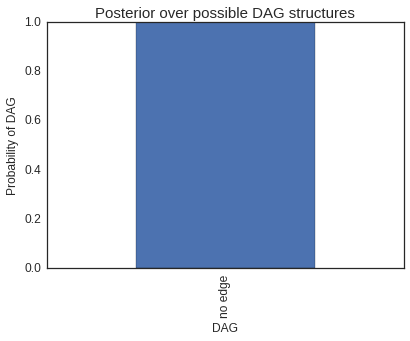

In [14]:
%%venturescript
plot_posterior_dags(posterior_samples);

## 4. Causal discovery for  two dependent nodes

#### Data as in  Fig. 1 subplot (ii).

In [15]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [16]:
%%venturescript
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";

Next, we define which columns (this time, "c" and "d") in the data table used for population and metamodel are to be considered for structure learning.

In [17]:
%%venturescript
define list_of_nodes = ["c", "d"];
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

### VentureScript structure learning

(same program as above. The SP that implements the observation function, has an unincorporate method which is currently broken. Therefore, I have to run the model to sample DAGs from scratch.) 

In [18]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, here run into a limitation of
                                   // venture, namely, [1] + [2] is [3]
                                   // whereas [1] + [2,3] is [1,2,3], which
                                   // is the desired behaviour. Therefore,
                                   // we need another condition to catch 
                                   // this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};

assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv((i) -> {
        mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

__CAVEAT:__ The purpose of this notebook is to illustrate that this technique works - I am misusing at least one of Venture's abstractions; namely, I am observing the following:  

In [19]:
%%venturescript
observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

### Inference

We take 10 MH steps to account for burn in.

In [20]:
%%venturescript
mh(default, all, 10);

Next, we collect 20 samples from the posterior. 
Note that `dag_to_dot_notation` takes the matrix form of a DAG and turns
it into dot notation, i.e. `(c)->(d)` for a DAG that has one edge from column c to do d.

In [21]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(20)));

### Result

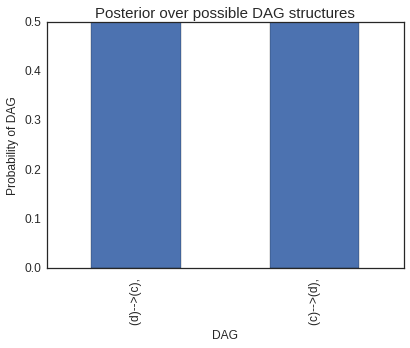

In [22]:
%%venturescript
plot_posterior_dags(posterior_samples);

## 5. Causal discovery for  a V-structure

#### Data as in  Fig. 1 subplot (ii).

In [23]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [24]:
%%venturescript
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";

In [25]:
%%venturescript
define list_of_nodes = ["e", "f", "g"];
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

Now the list of queries also contains queries for conditional mutual information

In [27]:
queries = %venturescript list_of_cmi_queries
for query in queries:
    print query

DROP TABLE IF EXISTS mi_e_f;
CREATE TABLE  mi_e_f AS
            SIMULATE
                MUTUAL INFORMATION OF e WITH f
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
DROP TABLE IF EXISTS mi_e_g;
CREATE TABLE  mi_e_g AS
            SIMULATE
                MUTUAL INFORMATION OF e WITH g
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
DROP TABLE IF EXISTS mi_f_g;
CREATE TABLE  mi_f_g AS
            SIMULATE
                MUTUAL INFORMATION OF f WITH g
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
DROP TABLE IF EXISTS mi_e_f_given_g;
CREATE TABLE  mi_e_f_given_g AS
            SIMULATE
                MUTUAL INFORMATION OF e WITH f
                GIVEN (g)
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
DROP TABLE IF EXISTS mi_e_g_given_f;
CREATE TABLE  mi_e_g_given_f AS
            SIMUL

### VentureScript structure learning

(same program as above. The SP that implements the observation function, has an unincorporate method which is currently broken. Therefore, I have to run the model to sample DAGs from scratch.) 

In [28]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, here run into a limitation of
                                   // venture, namely, [1] + [2] is [3]
                                   // whereas [1] + [2,3] is [1,2,3], which
                                   // is the desired behaviour. Therefore,
                                   // we need another condition to catch 
                                   // this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};



assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv(
        (i) -> {mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

__CAVEAT:__ The purpose of this notebook is to illustrate that this technique works - I am misusing at least one of Venture's abstractions; namely, I am observing the following:  

In [29]:
%%venturescript
observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

### Inference

This time, we run a longer burn-in period (100 transition of resimulation MH).

In [30]:
%%venturescript
mh(default, all, 100);

Next, we collect 50 samples from the posterior. 
Note that `dag_to_dot_notation` takes the matrix form of a DAG and turns
it into dot notation, i.e. `(a)->(b)` for a DAG that has one edge from 
column c to do d or `no edge` if all entries in the DAG matrix are false.

In [31]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(50)));

### Result

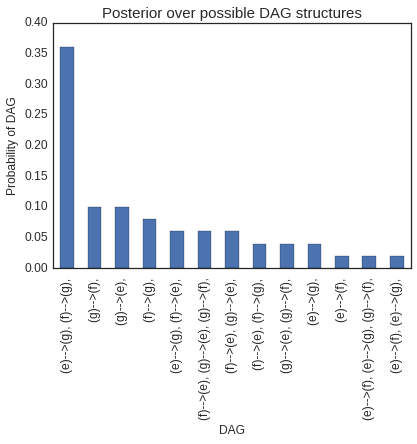

In [32]:
%%venturescript
plot_posterior_dags(posterior_samples);

## 6. Known issues:

- the `unincorporate` of the SP that implements the observation function for causal discovery is currently broken, therefore, we have to start a new RIPL
	and repeat the cell with the structure learning program three times,
    one for each set of of columns we look at.
-  For the implementation of the observation function I am miss-using abstractions. It is clear to me that this observation function should not observe CMI but the actual, raw data. Then, we can use crosscat to simulate. 
	I decided to leave it in this state to discuss and get feedback.
- The current implementation is slow - I need to think about good inference 
	schemes to speed up causal discovery.